# Histology-MRI-9p4T

**Overview**

This notebook will examine ex-vivo histology data from the BigBrain, 3D PLI, and AHEAD brain datasets. First wewill look at morphological features in unfolded space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy
import hippomaps as hm
from hippomaps.build_mpc import build_mpc
from brainspace.gradient import GradientMaps

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['struct-HISTO-unproc.npy'])
skipPreproc = True # this can be a bit slow, but checkpoints for either choice are available
if skipPreproc:
    hm.fetcher.get_tutorialCheckpoints(['struct-HISTO-proc.npy'])

# locate input data
source_dir = '/host/cassio/export03/data/unfolded_registration/BIDS/'
hippunfold_dir = '/host/cassio/export03/data/unfolded_registration/hippunfold_v1.3.0_100um/hippunfold'

# define which subjects and surfaces to examine
subs = ['bbhist', 'bbhist', 'bbhist2', 'bbhist2', 'pli3d', '122017', '122017', '152017', '152017']
ses = ''
hemis = ['L','R','L','R','L','L','R','L','R'] # unlike other tutorials, here we only have one hemisphere for some subjects, and so we define `subs` and `hemis` in concert
labels = ['hipp']
den='unfoldiso'

# here we will generate multiple depth-wise surfaces
depths = np.linspace(-0.25,1.25,num=25) # surfaces will extend 25% above and below the hippocampus to capture any missed grey matter
gm = np.where(np.logical_and(depths>=0,  depths <=1))[0] # index of original grey matter region

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

## 0) Map and load volumetric data to surfaces

As in all tutorials here, this step is OPTIONAL, and will be skipped by default. It provides an example of how data can be mapped to hippocampal surfaces outside of python (using `wb_command`). This relies on having the data stored locally, and should be considered example code. This code may differ depending on where/how your data is stored and formatted, and so may require some customization for new projects. For the purposes of this tutorial, we provide a matrix of loaded data at the end, so skip to the next step.

In this example, we loop through samples (that is, subjects and hemipsheres) and generate surfaces at different depths using the `wb_command` tool. Then, we loop through each modality and sample the data to those surfaces. Finally, we load the data from all surfaces into a single matrix.

In [3]:
if not useCheckpoints:

    # Create surfaces at various depths, and sample image intensities onto them
    hipp_dat = np.zeros([nV,len(depths), len(subs)])*np.nan
    for s,sub in enumerate(subs):
        cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
        !{cmd}
        for d,depth in enumerate(depths):
            for l,label in enumerate(labels):
                cmd1 = f'wb_command -surface-cortex-layer '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-{den}_label-{label}_inner.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemis[s]}_space-corobl_den-{den}_label-{label}_outer.surf.gii '\
                    f'{depth} '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{depth}.surf.gii'
                !{cmd1}
                cmd2 = f'wb_command -volume-to-surface-mapping '\
                    f'{source_dir}/sub-{sub}/anat/sub-{sub}_hemi-{hemis[s]}.nii.gz '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{depth}.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{depth}_intensity-default.shape.gii '\
                    f'-trilinear'
                !{cmd2}
                hipp_dat[iV[l],d,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemis[s]}_layer-{depth}_intensity-default.shape.gii').darrays[0].data

    # add extra modalities from AHEAD
    # here the surfaces remain the same as above, but we map additional volumetric modalities to them
    ahead_additional_modalities =  ['Bieloschowsky-interpolated', 'calbindin-interpolated', 'calretinin-interpolated', 'parvalbumin-interpolated', 'thionin-interpolated', 'MRI-proton-density', 'MRI-quantitative-R1', 'MRI-quantitative-R2star']
    for m,modality in enumerate(ahead_additional_modalities):
        for s in [5,6,7,8]:
            vol = np.zeros((hipp_dat.shape[:2]))
            for d,depth in enumerate(depths):
                cmd2 = f'wb_command -volume-to-surface-mapping '\
                    f'{source_dir}/sub-{subs[s]}/anat/sub-{subs[s]}_{modality}.nii.gz '\
                    f'{hippunfold_dir}/sub-{subs[s]}/surf/depths/sub-{subs[s]}_hemi-{hemis[s]}_layer-{depth}.surf.gii '\
                    f'{hippunfold_dir}/sub-{subs[s]}/surf/depths/sub-{subs[s]}_hemi-{hemis[s]}_layer-{depth}_intensity-{modality}.shape.gii '\
                    f'-enclosing'
                !{cmd2}
                vol[:,d] = nib.load(f'{hippunfold_dir}/sub-{subs[s]}/surf/depths/sub-{subs[s]}_hemi-{hemis[s]}_layer-{depth}_intensity-{modality}.shape.gii').darrays[0].data
            hipp_dat = np.concatenate((hipp_dat, np.expand_dims(vol,axis=2)), axis=2)

    np.save("checkpoints/struct-HISTO-unproc",hipp_dat, allow_pickle=True)

## 1) Load, plot, and preprocess all surface data

Here, we use the data already loaded into a large matrix from the previous step). This matrix `hipp_dat` has a shape of (number of vertices nV) x (number of surface depths) x (number of samples OR features)

In [4]:
hipp_dat = np.load("checkpoints/struct-HISTO-unproc.npy")

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


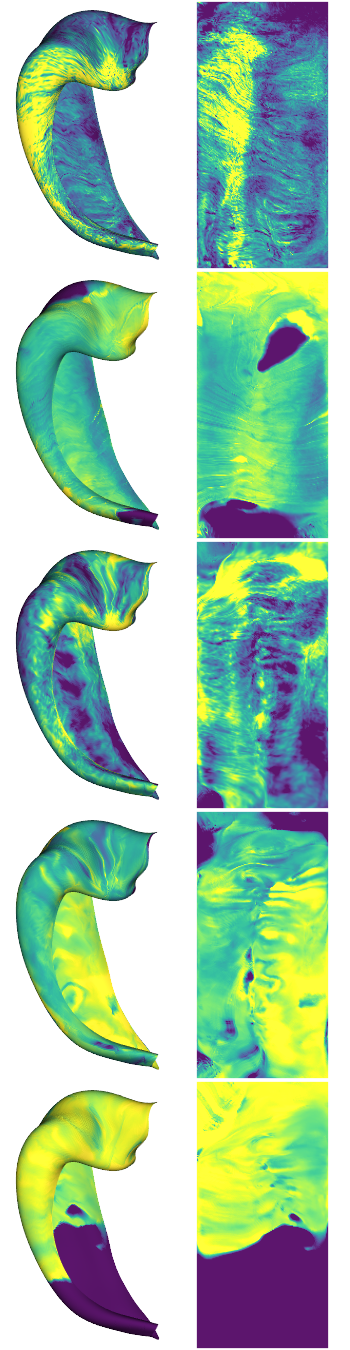

In [5]:
# inspect some example maps. We will plot all data as if it were from a left hemisphere, for simplicity. 
# Note that here, we average across all depths that are within the hippocampal bounds (i.e. depths 0-1)
examples = [0,4,6,10,13]
cdata = hipp_dat[:,:,examples]
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm],axis=1), labels=labels, hemis=['L'], den=den, size=[350,270], tighten_cwindow=True, embed_nb=True)

**Preprocessing**

Clearly these images will need some preprocessing to account for issues like missing data, impofect alignment between AHEAD stains, and imperfect surfaces

**Missing data**

For this, we will set all background values (sometimes 0, sometimes an integer like 2 or -1) to NaN. Then we will find outliers and also set them to NaN. Then we will dilate the mask of NaNs, because some edge cases are not exactly 0, but are not plausible values either. Then, we will interpolate the NaNs (linear) and extrapolate any remaining values (nearest)

In [6]:
def fill_missing(cdata):
    # note cdata must be unflded gridded data (i.e. 126x254xdepths instead of nVxdeapths). This is only possible in den-unfoldiso, so consider using hm.utils.density_interp for other data.

    cdata[np.isin(cdata, [-1,0,1,2])] = np.nan # any of these exact values are very likely from background
    
    # find LOCAL outliers (smooth the image and then find values that are >4 S.D. from the smoothed version)
    cdata_localOutliers = cdata - scipy.ndimage.gaussian_filter(cdata,[10,10,1])    
    cdata_localOutliers = scipy.stats.zscore(cdata_localOutliers, axis=None, nan_policy='omit')
    cdata[cdata_localOutliers>4] = np.nan
    cdata[cdata_localOutliers<-4] = np.nan
    
    # take edges off missing data too
    cdata[np.where(scipy.ndimage.morphology.binary_dilation(np.isnan(cdata), structure = np.ones((5,5,5))))] = np.nan 
    
    # interpolate NaNs
    good = np.where(~np.isnan(cdata))
    bad = np.where(np.isnan(cdata))
    fill = scipy.interpolate.griddata(good, cdata[good], bad)
    cdata[bad] = fill
    
    # extrapolate any values that are still missing
    good = np.where(~np.isnan(cdata))
    bad = np.where(np.isnan(cdata))
    fill = scipy.interpolate.griddata(good, cdata[good], bad, method='nearest')
    cdata[bad] = fill
    return cdata

**Alignment method**

Here we develop a tool to depth-wise or laminar align profiles, since the grey matter boundaries may not be perfect. We use only translations, and maximize the correlation between each profile and the average. This can be applied either over the whole image or over image patches, and we will illustrate an example using each.

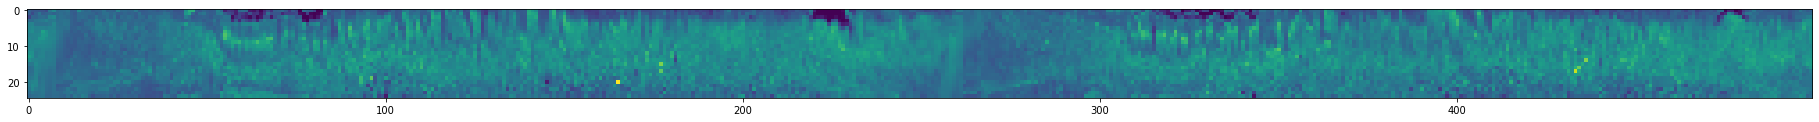

In [7]:
# view an example set of laminar profiles from the first sample

s=0

fig, ax = plt.subplots(figsize=(32, 4))
ax.imshow(hipp_dat[500:1000,:,s].T)

**Note** that the very top and very bottom of the data actually come from outside of our original hippocampal bounds, since surfaces were extrapolated out over these areas. 

Notice how in some areas the profiles are raised or lowered. Ths can happen due to imperfect segmentation - sometimes the hippocampal boundaries may have been inadvertently shifted upwards or downwards. In the AHEAD dataset this can also arise because even when segmentation is perfect, the alignment between the different modalities is still off. This is the problem we aim to correct here.

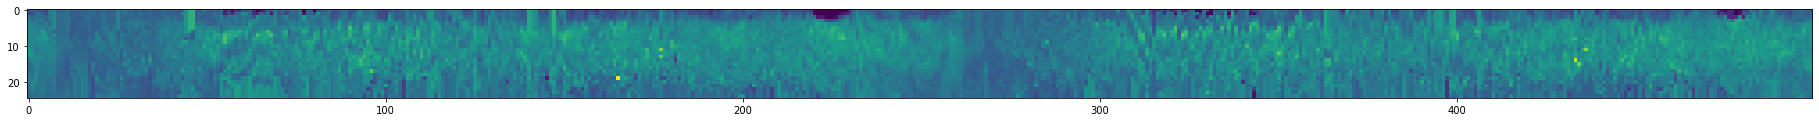

In [8]:
fig, ax = plt.subplots(figsize=(32, 4))
tdat = hm.utils.profile_align(hipp_dat[:,:,s])
ax.imshow(tdat[500:1000,:].T)

The default profile_align method aligns each profile to a global average of all profiles. This is computationally relatively fast, and robust since it won't be affected by local "drift" of a segmentation or registration away from the actual hippocampal boundaries.

In [9]:
# Now that we've defined our outlier handling and microstructural profile alignment methods, we can apply them to all subjects. 
# Here we also apply z-score normalization for easier comparison between image types, which can otherwise have drastically different ranges.
if not skipPreproc:
    hipp_dat_clean = np.zeros(hipp_dat.shape)
    for s in range(hipp_dat.shape[2]):
        cdata = np.reshape(hipp_dat[:,:,s], [126,254,25])
        # missing data
        cdata = fill_missing(cdata)
        # profile alignment
        cdata = hm.utils.profile_align(np.reshape(cdata,(nV,25)))
        # normalize with interpolated data
        cdata = scipy.stats.zscore(cdata, axis=None)
        
        hipp_dat_clean[:,:,s] = np.reshape(cdata,[nV,25])
    np.save("checkpoints/struct-HISTO-proc",hipp_dat_clean, allow_pickle=True)

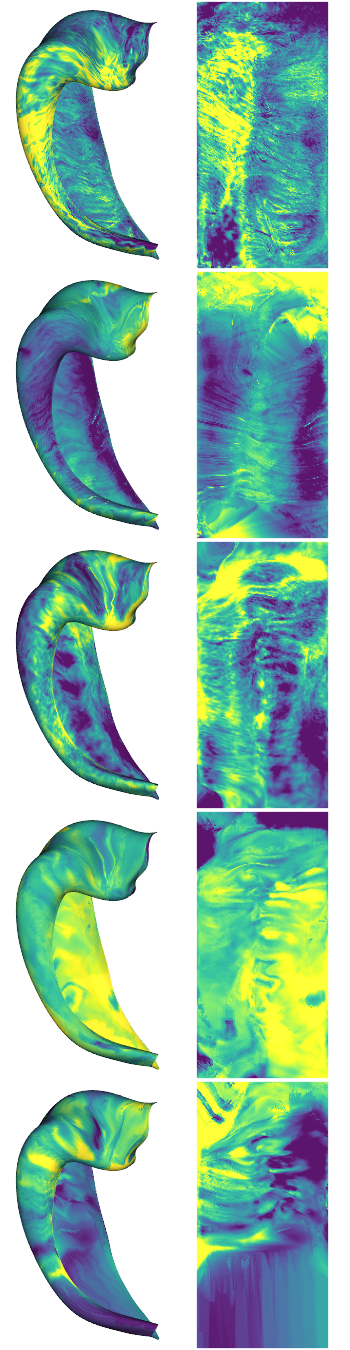

In [10]:
hipp_dat_clean = np.load("checkpoints/struct-HISTO-proc.npy")

# inspect some example maps
examples = [0,4,6,10,13]
cdata = hipp_dat_clean[:,:,examples]
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm],axis=1), labels=labels, hemis=['L'], den=den, size=[350,270], tighten_cwindow=True, embed_nb=True)

## 2) Group average and laminar microstructural profiles

This looks pretty good, so lets run some analyses. First we average within the same stain types, and look at some laminar profiles. 

At this stage we will also discard the bigbrain2 (bbhist2) samples since they require further 3D reconstruction refinement at this time. 
We will also discard the 9.4T MRI data here. We'll group that together with the 7T MRI data and examine it in that tutorial

In [11]:
# group subjects within the same modality
modalities = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin']#, 'ProtonDensity', 'qR1', 'qR2star']

modality_data = np.stack((np.nanmean(hipp_dat_clean[:,:,0:1],axis=2), hipp_dat_clean[:,:,4]),axis=2) # EXCLUDING bb2 for now
for m in range(6):
    modality_data = np.concatenate((modality_data, np.nanmean(hipp_dat_clean[:,:,(m*4 +5):(m*4 +9)],axis=2)[:,:,None]),axis=2)
modality_data.shape

(32004, 25, 8)

Now we have data in the shape of (number of vertices nV) x (number of depths) x (number of stains)

[-1.79532949 -1.83864671 -0.83829352 -2.94311749 -1.30977106 -1.54282194
 -2.10649163 -3.03733276] [2.7037219  3.42278981 1.9957718  1.08404999 1.97442552 1.95654471
 1.90293373 1.52232036]


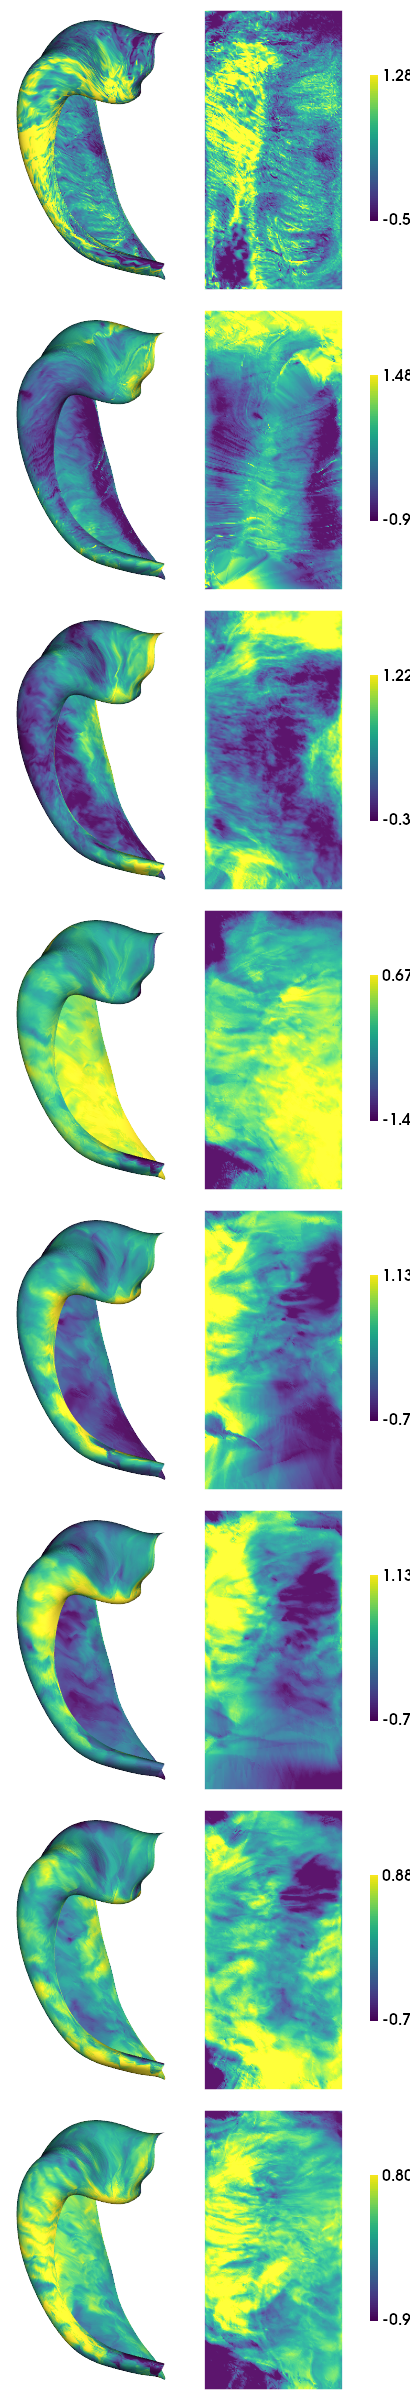

In [12]:
print(f'{np.min(np.nanmean(modality_data[:,gm,:],axis=1), axis=0)} {np.max(np.nanmean(modality_data[:,gm,:],axis=1), axis=0)}')
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(modality_data[:,gm,:],axis=1), labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, color_bar='right', share='row',  tighten_cwindow=True, embed_nb=True)

**View Laminar profiles**

Here we will view laminar profiles averaged within band across the anterior-posterior and then proximal-distal axes of the hippocampus.

Because we are working with `den='unfoldiso'` surfaces, we can reshape the number of vertices from 32K into 126x254. This way, we can average rows or columns to get a sense of how the profiles are changing in either direction

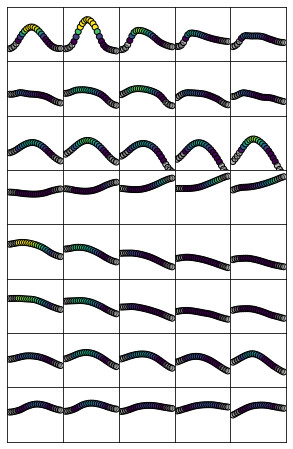

In [13]:
nsamp=5 # how many band to separate the data into
sampPD = np.linspace(0,126,nsamp+1).astype('int') # get sampling indices by dividing this axis into nsamp bands
md = np.reshape(modality_data,[126,254,25,len(modalities)])

fig, ax = plt.subplots(nrows=len(modalities), ncols=nsamp, figsize=(1*nsamp,1*len(modalities)))
for s in range(len(modalities)):
    
    # get limites for all axes in this row
    l = np.nanmean(md[:,:,gm,s],axis=2).flatten()
    lims = [min(l)-.5, max(l)+.5]
    
    for i in range(nsamp):
        # average within each nsamp band
        dat = np.nanmean(md[sampPD[i]:sampPD[i+1],:,:,s],axis=(0,1))
        
        # colour by intensity, and gry out data outside of the grey matter bounds
        col = plt.cm.viridis(dat)
        col[:,:][depths<0] = 0.5
        col[:,:][depths>1] = 0.5
        
        # plot
        ax[s,nsamp-i-1].scatter(depths,dat, c=col, edgecolors='black')
        ax[s,nsamp-i-1].set_ylim(lims)
        ax[s,nsamp-i-1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)

Note that for some stains, there is considerable variation in the shape of profiles across this axis. The first row (Merker stain) is a good example, which goes from a tight distribution at the distal areas (such as CA2 and CA3) to a shallower, almost bimodal distribution at the proximal areas (subiculum)

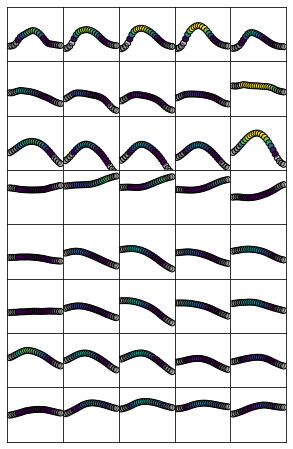

In [14]:
nsamp=5 # how many band to separate the data into
sampAP = np.linspace(0,254,nsamp+1).astype('int') # get sampling indices by dividing this axis into nsamp bands

fig, ax = plt.subplots(nrows=len(modalities), ncols=nsamp, figsize=(1*nsamp,1*len(modalities)))
for s in range(len(modalities)):
    
    # get limites for all axes in this row
    l = np.nanmean(md[:,:,gm,s],axis=2).flatten()
    lims = [min(l)-.5, max(l)+.5]
    
    for i in range(nsamp):
        # average within each nsamp band
        dat = np.nanmean(md[:,sampAP[i]:sampAP[i+1],:,s],axis=(0,1))

        # colour by intensity, and gry out data outside of the grey matter bounds
        col = plt.cm.viridis(dat)
        col[:,:][depths<0] = 0.5
        col[:,:][depths>1] = 0.5
        
        # plot
        ax[s,nsamp-i-1].scatter(depths,dat, c=col, edgecolors='black')
        ax[s,nsamp-i-1].set_ylim(lims)
        # ax[s,nsamp-i-1].axis('off')
        ax[s,nsamp-i-1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we see that profiles are relatively constant between rows. This means that profiles don't differ as greatly across the anterior-posterior extent of the hippocampus.

## 3) Summarize data according to primary gradients

Dimensionality reduction allows us to summarize many maps as primary components, or Gradients. Here we will use BrainSpace to compute nonlinear Gradients using diffusion map embedding. Briefly, this typically consists of computing an affinity matrix (e.g. a correlation between all maps) and then grouping them into a few consistent patterns (Gradients). In this case, we will consider not only the correlation between maps, but also across depths. All depths from a given vertex are sometimes called microstructural profiles (MPs), and the similarity between all profiles is thus a microstructural profile covariance (MPC) matrix. In this case we also consider multiple modalities, making a multimodal MPC (mMPC). 

In [15]:
mMP = np.reshape(modality_data[:,gm,:],(nV,-1)).T #flatten. Each vertex now has a vector of depths for all modalities.
mMPC, I, problemNodes = build_mpc(np.concatenate((mMP,np.mean(mMP,axis=0).reshape((1,-1))))) # compute mMPC

/export03/data/opt/hippomaps/hippomaps/build_mpc.py:145: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


(-0.5, 32003.5, 32003.5, -0.5)

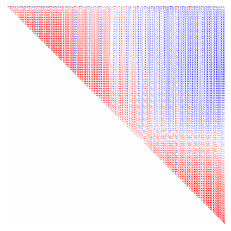

In [16]:
# plot the mMPC to get a sense of similarity between vertices.
plt.imshow(mMPC, vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

In [17]:
# multimodal gradient map (mGM) decomposition using default parameters 
nGrads = 3
mGM = GradientMaps()
mGM.fit(mMPC)

/export03/data/opt/BrainSpace/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps()

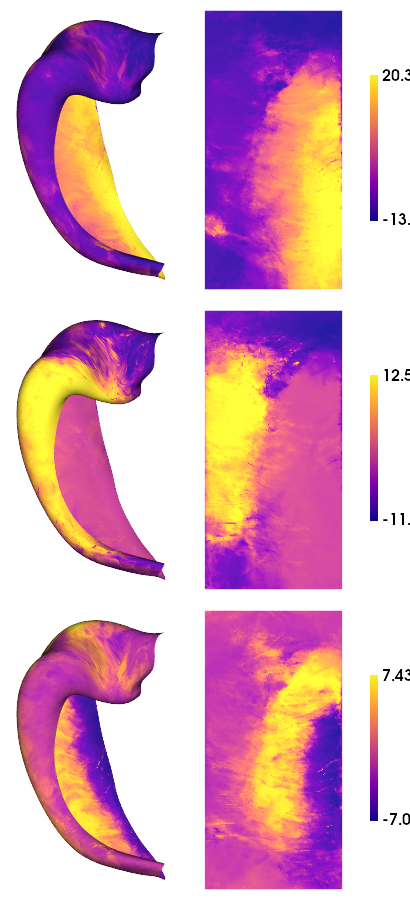

In [18]:
# As above, we can make a nice plot for each of the resulting gradients
hm.plotting.surfplot_canonical_foldunfold(mGM.gradients_[:,:nGrads], labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

[0.38873311 0.23044569 0.11883649 0.06794698 0.04072477 0.03875749
 0.03741271 0.0293696  0.02686627 0.02090689]


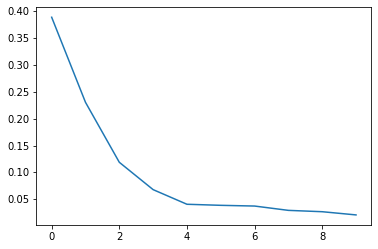

In [19]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(mGM.lambdas_/np.sum(mGM.lambdas_))
print(mGM.lambdas_/np.sum(mGM.lambdas_))

**save**

In [20]:
# save a copy of the 2D map
dataset = ['BigBrain','AxerPLI','AHEAD','AHEAD','AHEAD','AHEAD','AHEAD','AHEAD']
naverages = [2,1,4,4,4,4,4,4]
for m,modality in enumerate(modalities):
    for l,label in enumerate(labels):
        cdat = np.nanmean(modality_data[iV[l],:,m][:,gm],axis=1).flatten()
        data_array = nib.gifti.GiftiDataArray(data=cdat)
        image = nib.gifti.GiftiImage()
        image.add_gifti_data_array(data_array)
        method = "histology" if m<8 else "MRI-9p4T"
        cmd = f"mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-{dataset[m]}"
        !{cmd}
        nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-{dataset[m]}/{method}-{modality}_average-{naverages[m]}_hemi-mix_den-{den}_label-{label}.shape.gii')